In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import cobra
import snek
import pickle

In [2]:
ecoli = cobra.io.read_sbml_model('../models/iML1515_pDNA.xml')
ecoli.solver = 'cplex'

# Linear Feed

## Load Data

In [3]:
with open('../preprocessing/220829_dFBA_lin_feed_v04.pkl','rb') as file:
    lin_processed,lin_special_interest = pickle.load(file)
q_pDNA_max_levels = list(lin_processed.keys())
print(np.array(q_pDNA_max_levels))
q_pDNA_min = .1/100
del file

[0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005 ]


## Figure 4

[0.0, 0.59558812, 1.3929077, 1.9884958200000002, 2.22865232, 2.43999004]
178
(-0.01493893294075985, 0.4790248606105791) (0.0, 2.6)


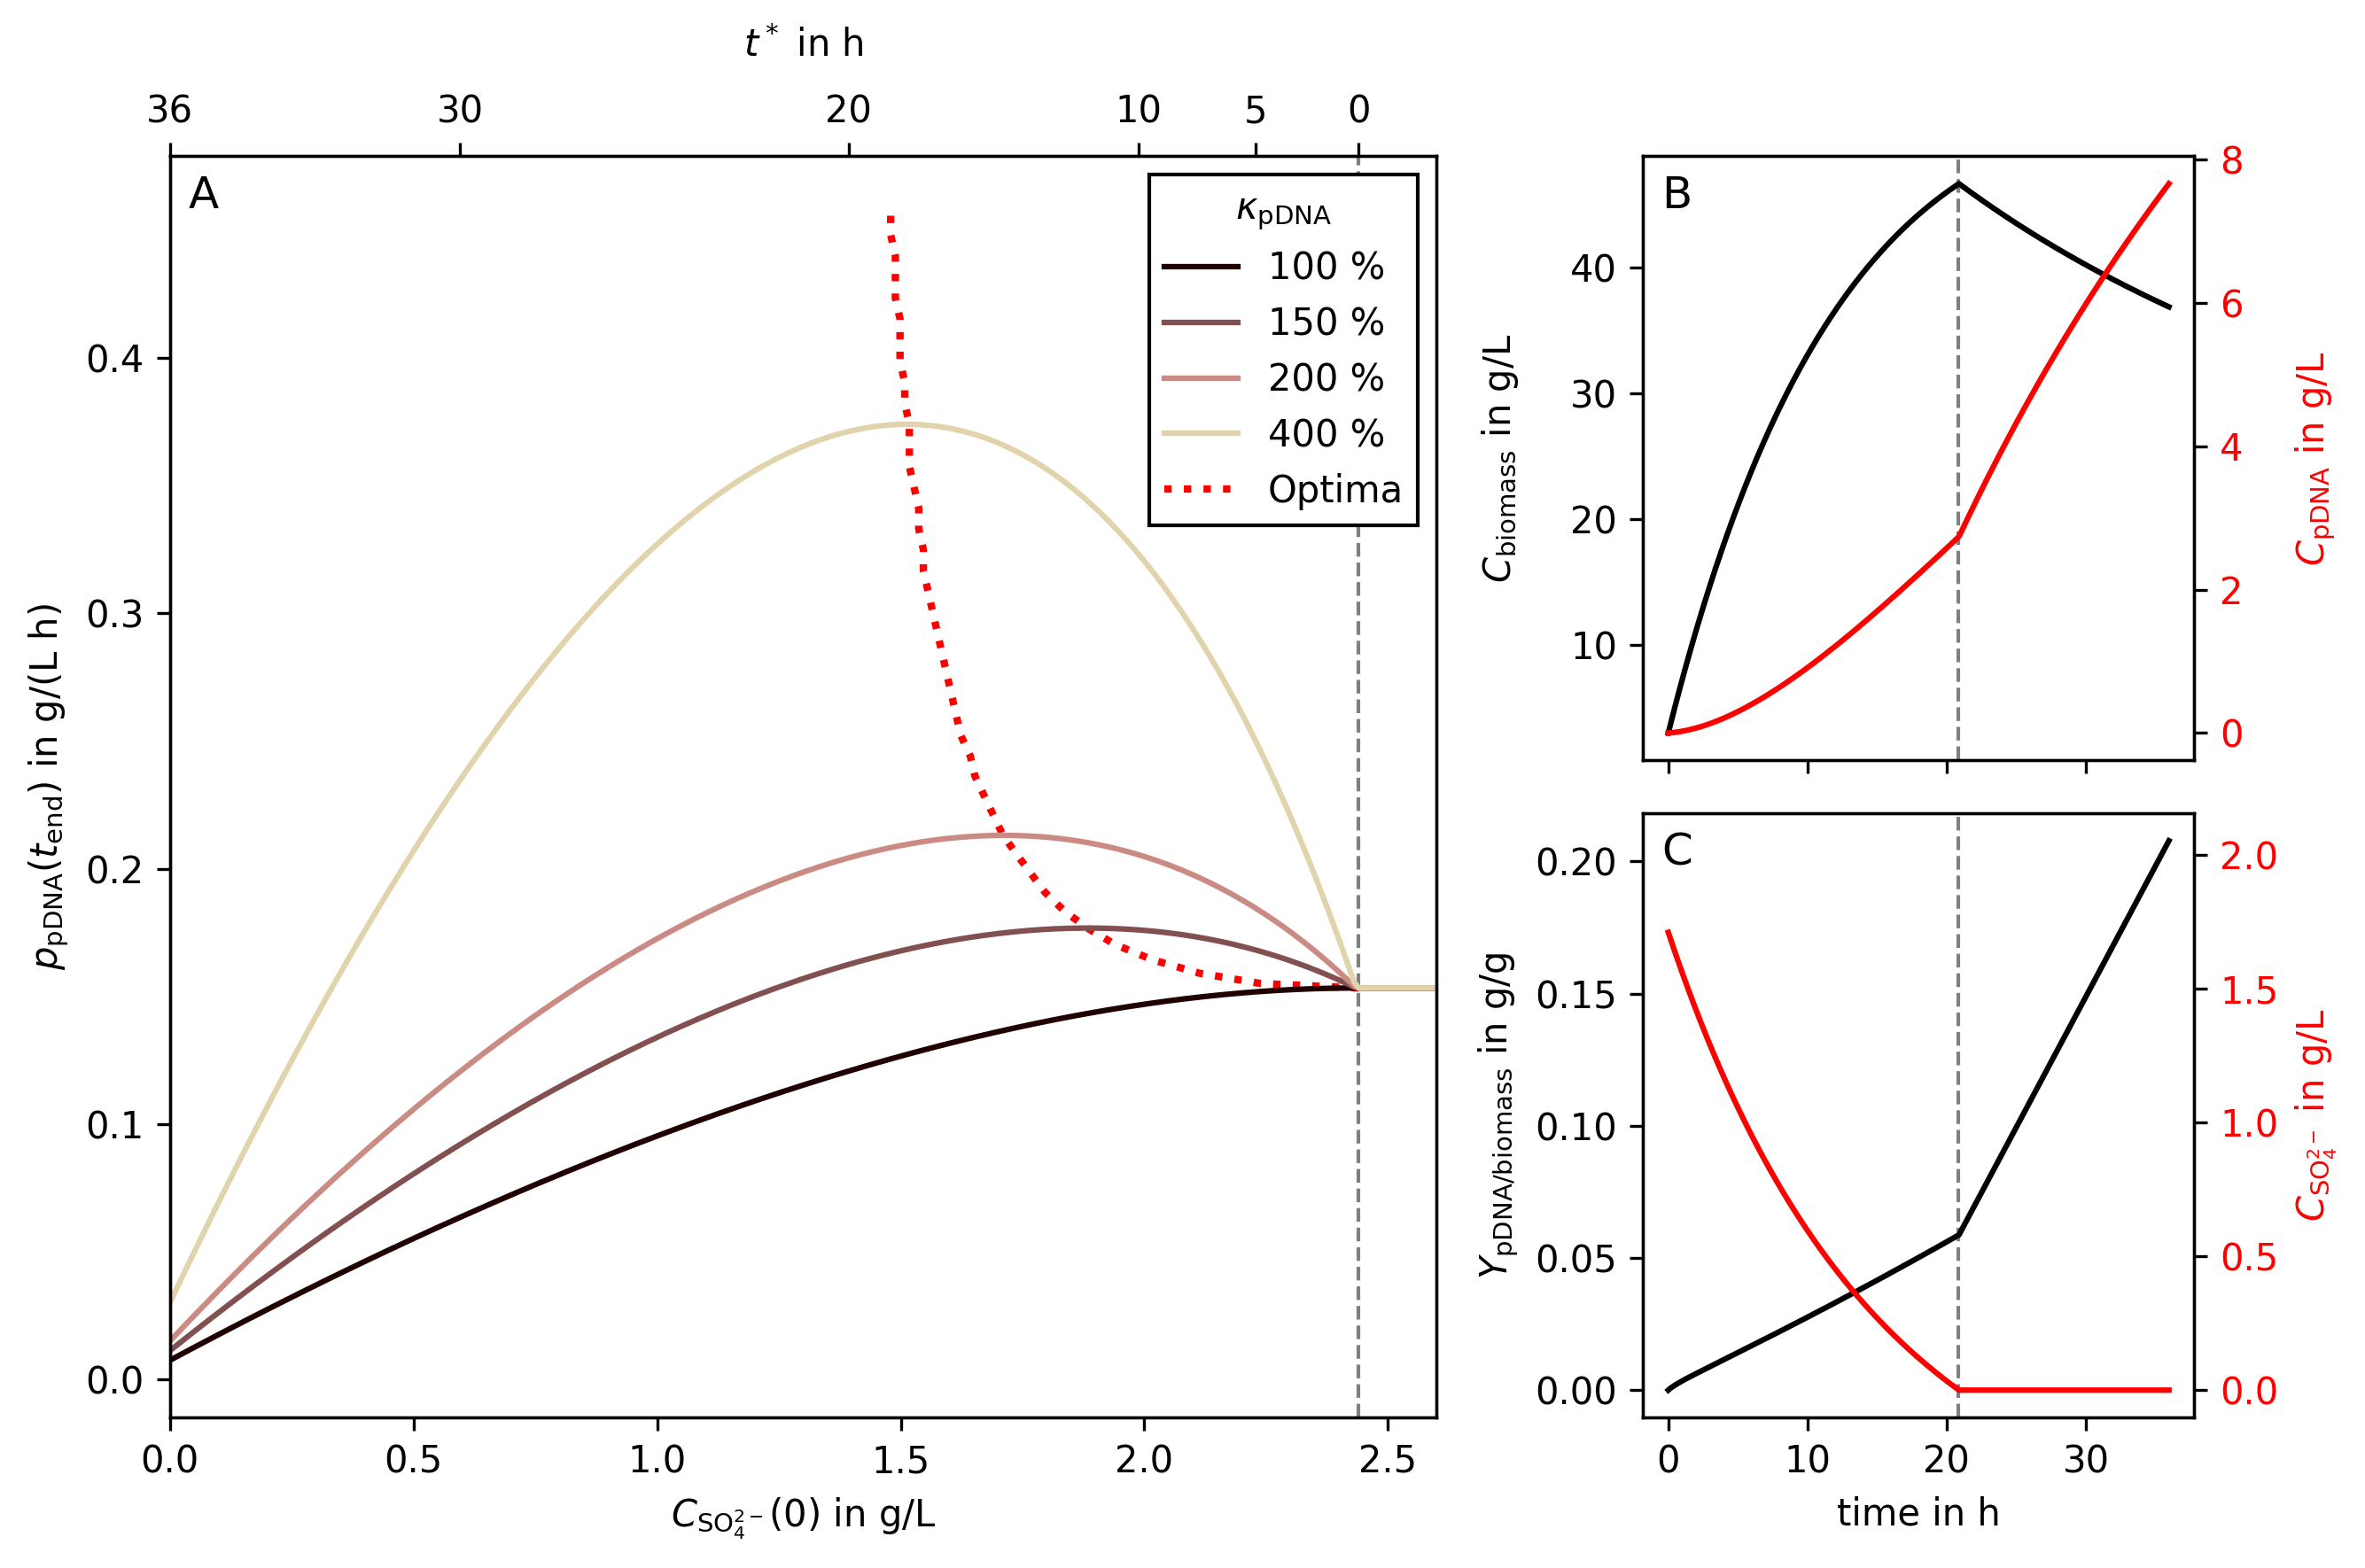

In [4]:
fig = plt.figure(dpi=300,figsize=(9,6))
fig.set_facecolor('w')
gs = fig.add_gridspec(nrows=4, ncols=2, width_ratios=[2.3,1], height_ratios=[1,.2,1,.2])
ax1 = fig.add_subplot(gs[0:,0])
ax2 = fig.add_subplot(gs[0:2,1])
ax3 = fig.add_subplot(gs[2: ,1])
ax1v2 = ax1.twiny()
ax2v2 = ax2.twinx()
ax3v2 = ax3.twinx()

#-----------#
#### AX1 ####
#-----------#

tol = 1e-8
colors = ['#200001','#825051','#cb8b85','#e1d3ab','#f7f7e6']
optima_x = []
optima_y = []
l = 0
max_star_time = 100
for q_pDNA_max in q_pDNA_max_levels:
    endpoints          = lin_processed[q_pDNA_max]
    S_0_array          = endpoints[:,0] * ecoli.metabolites.so4_e.formula_weight / 1000 / .5    # mmol/L -> g/L
    t_end_array        = endpoints[:,1]
    V_end_array        = endpoints[:,2]
    X_end_array        = endpoints[:,3]
    S_end_array        = endpoints[:,4] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P_end_array        = endpoints[:,5] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G_end_array        = endpoints[:,6] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_start_array = endpoints[:,7]
    t_star_len_array   = t_end_array - t_star_start_array
    productivity       = P_end_array/t_end_array/V_end_array

    if np.any([np.isclose(i,q_pDNA_max) for i in [.1/100,.15/100,.2/100,.4/100]]):
        ax1.plot(S_0_array,productivity,
                 color=colors[l], # cm.pink(q_pDNA_max/q_pDNA_min/5),
                 label='{:3.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
        l += 1
    optima_x.append(S_0_array[np.argmax(productivity)])
    optima_y.append(np.max(productivity))
    # find index of best process
    if q_pDNA_max == .2/100:
        idx_optimum_zero_q_pDNA = np.argmax(productivity)
    
# plot optima and starvation cutoff
ax1.plot(optima_x,optima_y,zorder=-1,color='red',linestyle=':',label='Optima',linewidth=2)
# plot starvation cutoff
ylim = ax1.get_ylim()
t_star = optima_x[0]
ax1.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(ylim)

# second X-axis
ax1.set_xlim(0,2.6)
ax1_x2ticks = []
ax1_x2ticklabels = []
for i in np.array([36,30,20,10,5,0]): #reduced_int_t_star_start
    idx = np.argmin(np.abs(np.nan_to_num(t_star_len_array,nan=np.inf)-i))
    if i == 0:
        ax1_x2ticks.append(optima_x[0])
    else:
        ax1_x2ticks.append(S_0_array[idx])
    ax1_x2ticklabels.append(i)
ax1_x2ticklabels = ['36','30','20','10','5','0']
print(ax1_x2ticks)
ax1v2.set_xticks(ax1_x2ticks)
ax1v2.set_xticklabels(ax1_x2ticklabels)
ax1v2.set_xlim(ax1.get_xlim())

ax1v2.set_xlabel(r'$t^*$ in h',labelpad=10)
ax1.set_xlabel(r'$C_{\rm SO_4^{2-}}(0)$ in g/L')
ax1.set_ylabel(r'$p_{\rm pDNA}(t_{\rm end})$ in g/(L h)')
ax1.legend(fancybox=False,edgecolor='k',loc='upper right',framealpha=1,title=r'$\kappa_{\rm pDNA}$')
fig.tight_layout()

#################
## AX2 & AX3 ####
#################


def plot_sol(sol):
    S_0 = sol[0] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol[1]                                                    # h
    V   = sol[2]
    X   = sol[3]/V                                                    # g
    S   = sol[4]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol[5]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol[6]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_star = sol[7]                                            # h
    
    lines  = [X,P/X,P,S]
    colors = ['k','k','r','r']
    ylabs  = [r'$C_{\rm biomass}$ in g/L',r'$Y_{\rm pDNA/biomass}$ in g/g', r'$C_{\rm pDNA}$ in g/L', r'$C_{\rm SO_4^{2-}}$ in g/L']
    axes   = [ax2,ax3,ax2v2,ax3v2]

    for j in range(4):
        axes[j].plot(t,lines[j],label=r'$M_{\rm SO_4^{2-}}(t=0)$ ='+'{:6.3f}'.format(S_0)+' mmol/L',color=colors[j])
        axes[j].set_ylabel(ylabs[j],color=colors[j])
    return X,S,P,G,t,t[-1],V

results = lin_special_interest[.2/100]
print(idx_optimum_zero_q_pDNA)
for idx in [idx_optimum_zero_q_pDNA]:
    S_0 = list(results.keys())[idx]
    sol = results[S_0]
    X,S,P,G,t,t_end,V = plot_sol(sol)

for ax in [ax3v2]:
    tmp = ax.get_ylim()
    ax.set_ylim(np.array(tmp)*1.2)
    
for ax in [ax2,ax3]:
    ylim = ax.get_ylim()
    t_star = t[np.isclose(S,0,atol=1e-3)][0]
    ax.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
    ax.set_ylim(ylim)

ax3.set_xlabel('time in h')
ax2.set_xticklabels([])
for ax in [ax2v2,ax3v2]:
    ax.tick_params(axis='y', labelcolor='red')

    
import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',],[ax1,ax2,ax3]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

print(ax1.get_ylim(),ax1.get_xlim())
fig.align_ylabels()
fig.align_xlabels()
fig.tight_layout()
fig.show()

In [5]:
print('Optimal Starvation Length (for kappa = 500%) = {:.1f} h'.format(t_star_len_array[np.argmax(productivity)]))

Optimal Starvation Length (for kappa = 500%) = 18.8 h


In [6]:
star_idx = np.where(t==t_star)[0][0]
r_F_growth = 13.9/1000 # L/h
G_F = 329.88 # g/L glucose
r_F_G = r_F_growth*G_F # gG/h
r_F_G = r_F_G / snek.elements.molecular_weight('C6H12O6') * 1000 # mmol G/h
q_G = r_F_G/(X[star_idx]*V[star_idx])
print('q_G(t_star_start) = {:.3f} mmol/(gX h)'.format(q_G))

q_G(t_star_start) = 0.691 mmol/(gX h)


In [7]:
star_idx = 0
r_F_growth = 13.9/1000 # L/h
G_F = 329.88 # g/L glucose
r_F_G = r_F_growth*G_F # gG/h
r_F_G = r_F_G / snek.elements.molecular_weight('C6H12O6') * 1000 # mmol G/h
q_G = r_F_G/(X[star_idx]*V[star_idx])
print('q_G(0h) = {:.3f} mmol/(gX h)'.format(q_G))

q_G(0h) = 16.745 mmol/(gX h)


## Figure 7

In [8]:
results = lin_special_interest[.2/100]
sol = results[list(results.keys())[-1]]
S_0 = sol[0] #* ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
t   = sol[1]                                                    # h
V   = sol[2]
X   = sol[3]/V                                                    # g
S   = sol[4]/V #* ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
P   = sol[5]/V #* ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
G   = sol[6]/V #* ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
t_star_star = sol[7]          
productivity       = P[-1]/t[-1]
print('final productivity  {:.5f} mmol/(g h)'.format(productivity))
print('final concentration {:.5f} mmol/g'.format(P[-1]))

final productivity  0.03101 mmol/(g h)
final concentration 1.11515 mmol/g


In [9]:
with open('../preprocessing/220829_dFBA_lin_feed_v05_contour.pkl','rb') as file:
    tmp = pickle.load(file)
    cX = tmp[0] # q_pDNA_max in mmol/(g h)
    cY = tmp[1] # t* in h
    cZ = tmp[2] # p_pDNA in mmol/(g h)
rel_cX = cX/(.1/100)*100
rel_cZ = cZ/0.03105 *100

In [10]:
def plot_function(ax1):
    with open('../preprocessing/220829_dFBA_lin_feed_v05_v2.pkl','rb') as file:
        lin_processed,lin_special_interest = pickle.load(file)
        q_pDNA_max_levels = list(lin_processed.keys())
        q_pDNA_min = .1/100
    del file
    
    optimum_t_star_min = []
    optimum_relative_tstar_min = []
    optimum_t_star = []
    for q_pDNA_max in q_pDNA_max_levels:
        endpoints          = lin_processed[q_pDNA_max]
        S_0_array          = endpoints[:,0] * ecoli.metabolites.so4_e.formula_weight / 1000 / .5    # mmol/L -> g/L
        t_end_array        = endpoints[:,1]
        V_end_array        = endpoints[:,2]
        X_end_array        = endpoints[:,3]
        S_end_array        = endpoints[:,4] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
        P_end_array        = endpoints[:,5] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
        G_end_array        = endpoints[:,6] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
        t_star_start_array = endpoints[:,7]
        t_star_min_array   = endpoints[:,8]
        t_star_len_array   = t_end_array - t_star_start_array
        productivity       = P_end_array/t_end_array/V_end_array
        # print(t_star_min_array[np.argmax(productivity)],t_star_start_array[np.argmax(productivity)])
        optimum_t_star_min.append(t_star_min_array[np.argmax(productivity)]-t_star_start_array[np.argmax(productivity)])
        optimum_relative_tstar_min.append((t_star_min_array[np.argmax(productivity)]-t_star_start_array[np.argmax(productivity)])/(t_end_array[np.argmax(productivity)]-t_star_start_array[np.argmax(productivity)]))
        optimum_t_star.append(t_star_len_array[np.argmax(productivity)])
    ax1.plot(np.array(q_pDNA_max_levels)/q_pDNA_min*100,optimum_t_star_min,color='b',linestyle='-',label=r'$t^*_{\rm breakthrough}$',linewidth=2)
    # ax2.plot(np.array(q_pDNA_max_levels)/q_pDNA_min*100,optimum_relative_tstar_min,color='r',linestyle='-')
    ax1.plot(np.array(q_pDNA_max_levels)/q_pDNA_min*100,optimum_t_star,color='b',linestyle='--',label=r'$t^*$',linewidth=2)
    # ax1.fill_between(np.array(q_pDNA_max_levels)/q_pDNA_min*100,optimum_t_star,optimum_t_star_min,color='grey',alpha=.5,label='Overproduction',linewidth=0)
    return np.array(q_pDNA_max_levels)/q_pDNA_min*100,optimum_t_star_min
    
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

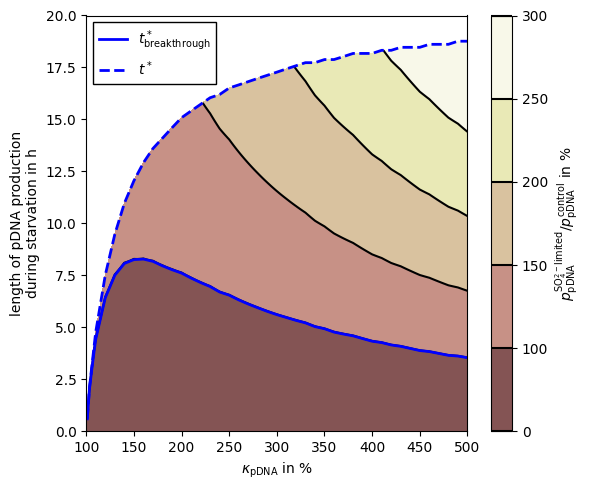

In [11]:
fig = plt.figure(dpi=100,figsize=(6,5))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111)

flevels = [0,100,150,200,250,300]
clevels = flevels #[0,150,200,250,300]
CSf = ax1.contourf(rel_cX, cY, rel_cZ, cmap=plt.cm.pink,levels=flevels)
CS  = ax1.contour(rel_cX,cY,rel_cZ,colors='k',levels=clevels)    
cbar = fig.colorbar(CSf,label=r'$p_{\rm pDNA}^{\rm SO_4^{2-} limited} / p_{\rm pDNA}^{\rm control}$ in %')
cbar.add_lines(CS)
kappa,t_breakthrough = plot_function(ax1)

for ax in [ax1]:
    ax.set_xlim(100,500)
ax1.set_xlabel(r'$\kappa_{\rm pDNA}$ in %')
ax1.set_ylabel('length of pDNA production\nduring starvation in h')
ax1.set_ylim(0,20)

plt.legend(edgecolor='k',fancybox=False,framealpha=1)
plt.tight_layout()
plt.show()

In [12]:
print('kappa(t_breakthrough^max) = {:.0f} %'.format(kappa[np.argmax(np.nan_to_num(t_breakthrough))]))
print('t_breakthrough^max        = {:.1f} h'.format(np.max(np.nan_to_num(t_breakthrough))))

kappa(t_breakthrough^max) = 160 %
t_breakthrough^max        = 8.3 h


In [13]:
print('kappa          = {:.0f} %'.format(*kappa[kappa == 200]))
print('t_breakthrough = {:.1f} h'.format(*np.array(t_breakthrough)[kappa==200]))

kappa          = 200 %
t_breakthrough = 7.6 h


## Figure S4

20.882088208820882
35.96159615961596
7.6147614761476135
nan
35.96159615961596


/tmp/ipykernel_3706001/361457980.py:22: RuntimeWarning: invalid value encountered in true_divide
  productivity = P/t/ctrl_productivity *100  # g/L/h
/tmp/ipykernel_3706001/361457980.py:27: RuntimeWarning: invalid value encountered in true_divide
  new_productivity = np.clip(P,a_max=P[t_star_production_end_idx],a_min=-np.inf)/t/ctrl_productivity * 100


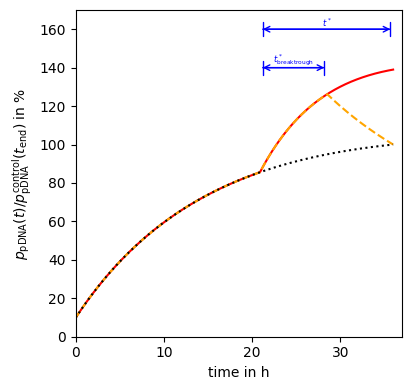

In [14]:
fig = plt.figure(dpi=100,figsize=(5,4))
fig.set_facecolor('w')
ax = plt.subplot(111,box_aspect=1)
results = lin_special_interest[.2/100]
colors = ['r','k']
linestyles = ['-',':']
labels = [r'SO$_4^{2-}$ limited','control']
for nr, idx in enumerate([178,-1]):
    S_0 = list(results.keys())[idx]
    sol = results[S_0]
    S_0 = sol[0] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol[1]                                                    # h
    V   = sol[2]
    X   = sol[3]/V                                                    # g
    S   = sol[4]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol[5]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol[6]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_start = sol[7]           
    print(t_star_start)
    print(t[-1])
    ctrl_productivity = 0.03101 * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L/h -> g/L/h
    productivity = P/t/ctrl_productivity *100  # g/L/h
    plt.plot(t,productivity,color=colors[nr],linestyle=linestyles[nr],label=labels[nr])
    if nr == 0:
        t_star_production_end_idx = np.argmin(np.abs(np.nan_to_num(P)-(1.11515* ecoli.metabolites.pDNA_c.formula_weight / 1000)))
        print(t[t_star_production_end_idx]-t_star_start)
        new_productivity = np.clip(P,a_max=P[t_star_production_end_idx],a_min=-np.inf)/t/ctrl_productivity * 100
        plt.plot(t,new_productivity,color='orange',linestyle='--',label=r'SO$_4^{2-}$ limited')
        pass
    # break
plt.ylim(0,170)
plt.xlim(0,37)
plt.ylabel(r'$p_{\rm pDNA}(t) / p_{\rm pDNA}^{\rm control}(t_{\rm end})$ in %')
plt.xlabel('time in h')

left = 20.88
right = 35.96
height = 160
width = right-left
plt.annotate("", xy=(left, height), xytext=(right, height), textcoords=ax.transData, arrowprops=dict(arrowstyle='<->',color='b'))
plt.annotate("", xy=(left, height), xytext=(right, height), textcoords=ax.transData, arrowprops=dict(arrowstyle='|-|',color='b',mutation_scale=5))
plt.text((left+right)/2, height, r"$t^*$", ha="center", va="bottom",color='b',fontsize=6)

left = 20.88
right = left + 7.6
height = 140
width = right-left
plt.annotate("", xy=(left, height), xytext=(right, height), textcoords=ax.transData, arrowprops=dict(arrowstyle='<->',color='b'))
plt.annotate("", xy=(left, height), xytext=(right, height), textcoords=ax.transData, arrowprops=dict(arrowstyle='|-|',color='b',mutation_scale=5))
plt.text((left+right)/2, height, r"$t^*_{\rm breaktrough}$", ha="center", va="bottom",color='b',fontsize=6)

plt.tight_layout()
plt.show()

## Figure S2

This Figure is rendered wrongly in Jupyter but correctly when saved.
$\kappa_{\rm pDNA}$
100 %
150 %
200 %
400 %
Optima$(t^*_{\rm max})$
 20 h
 15 h
 10 h
  5 h


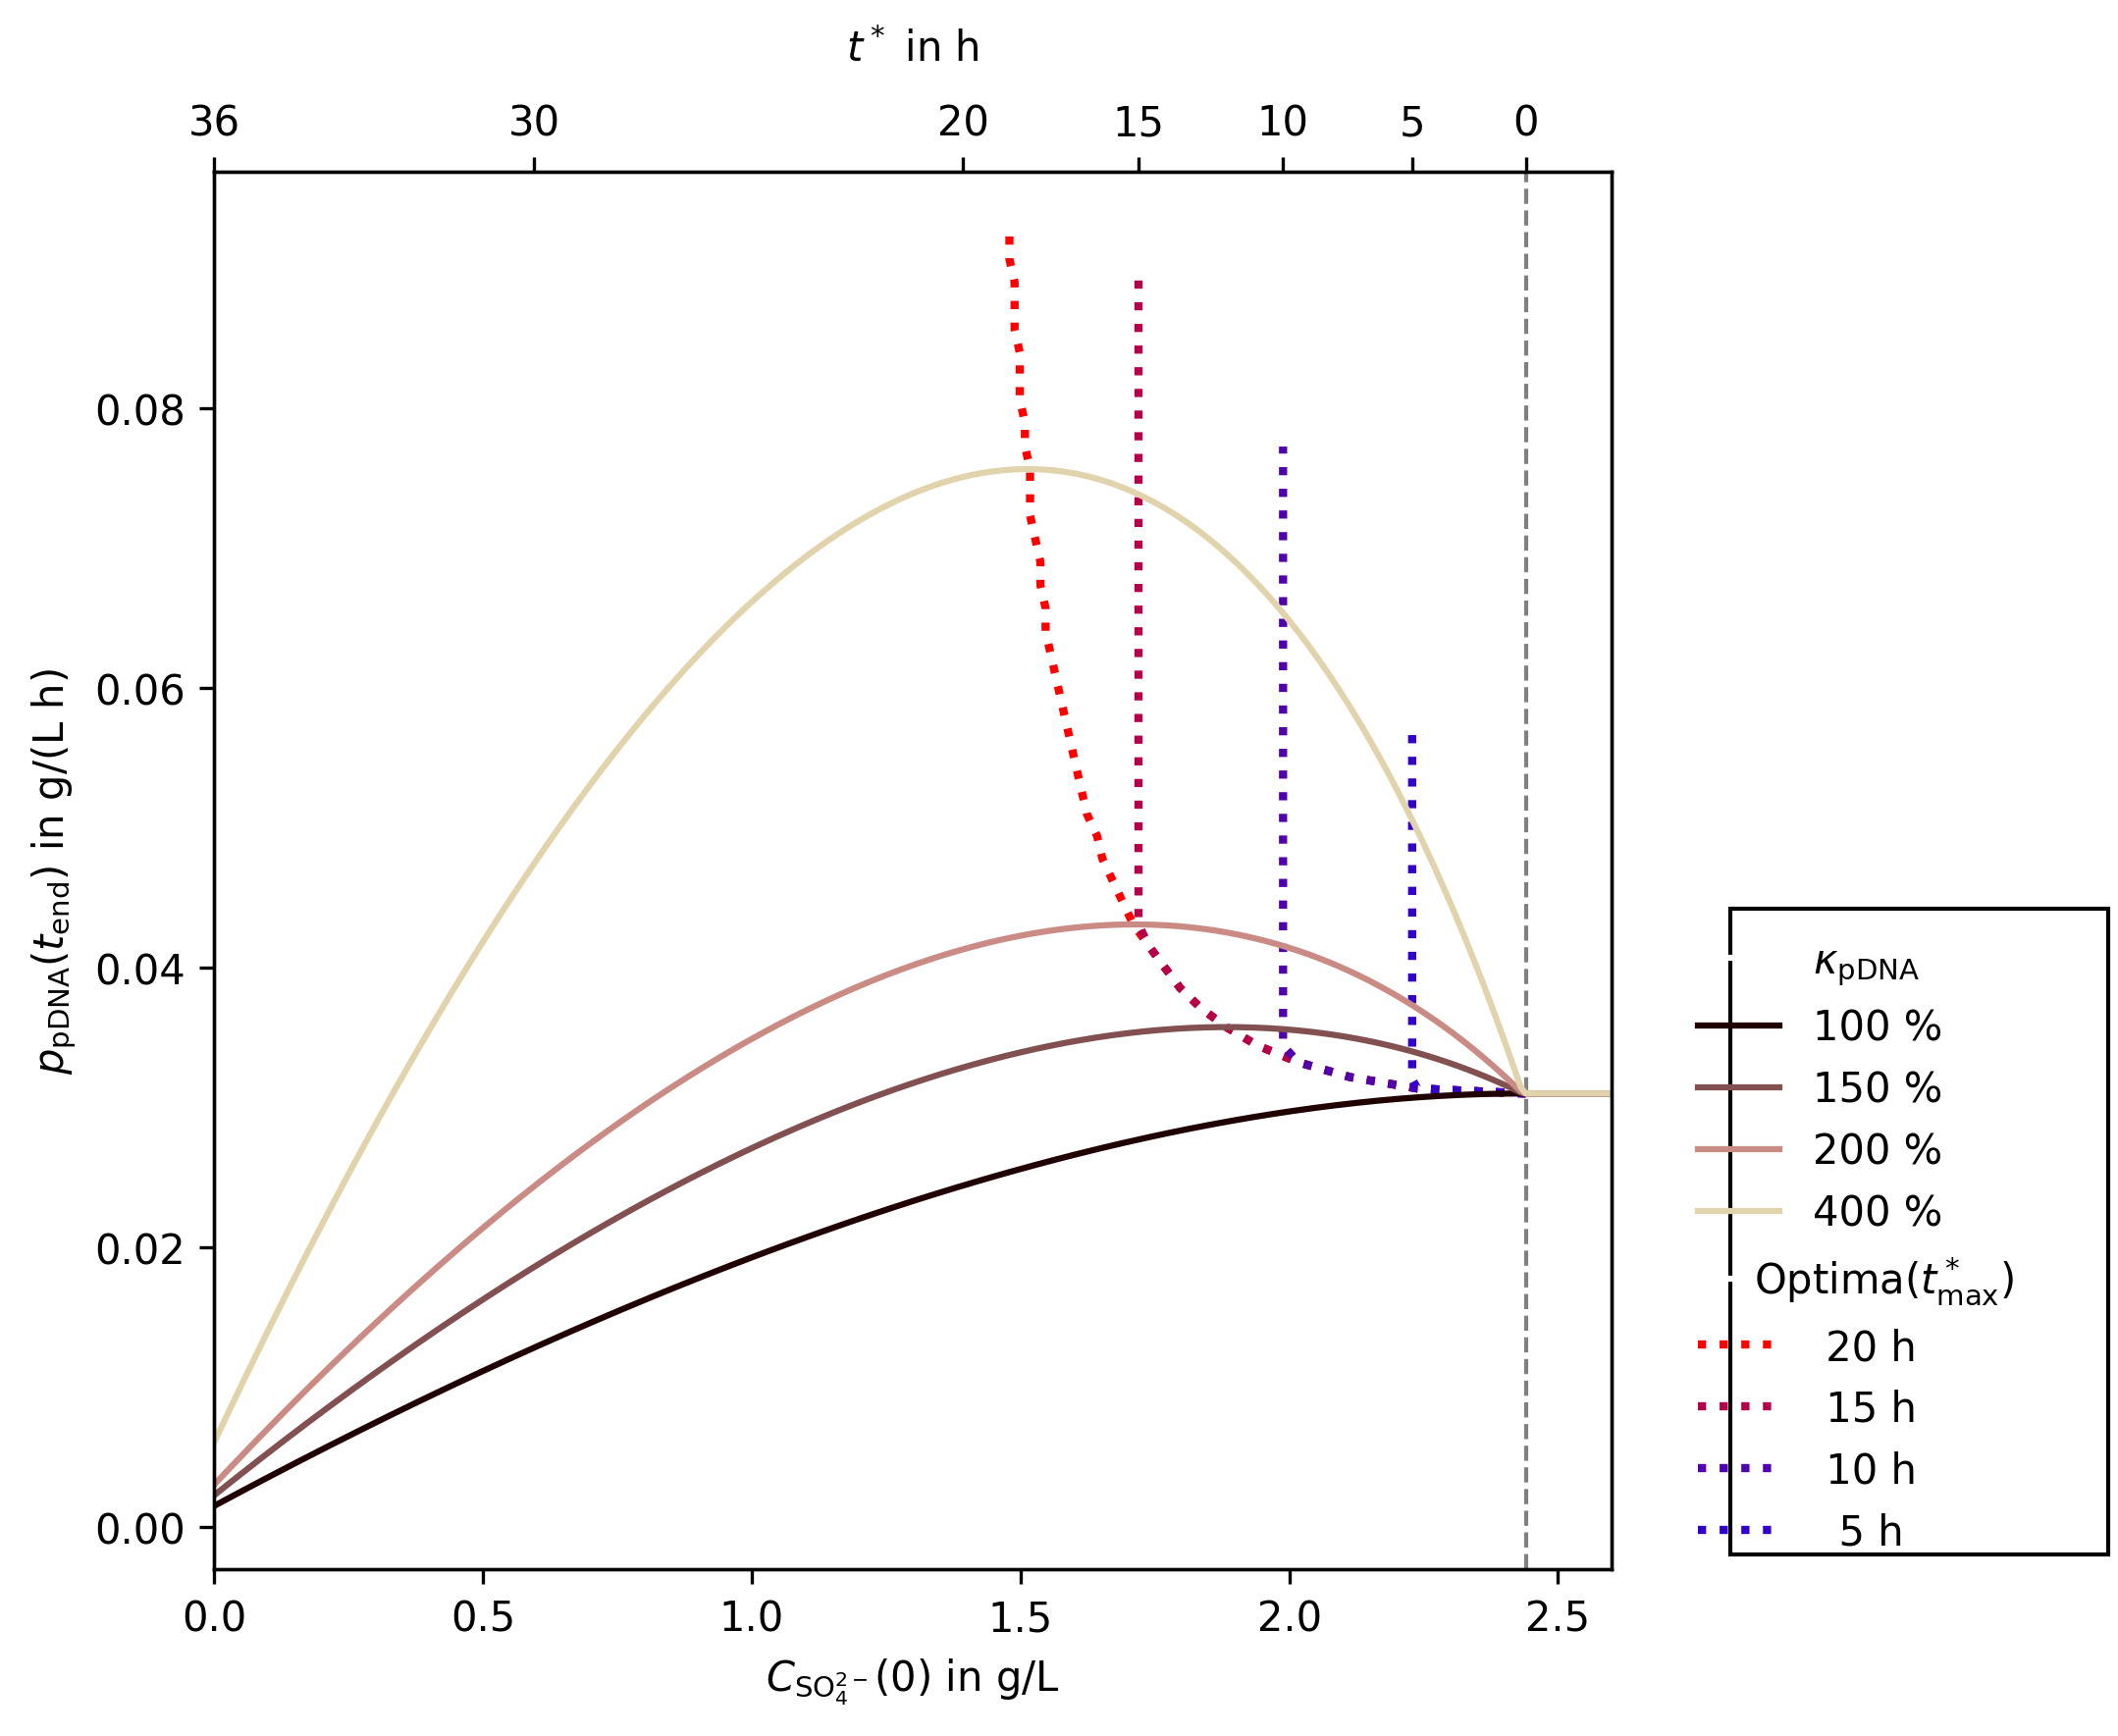

[1713.3858333333335, 169.7833333333333] 415.0062133789063 658.0333333333334


In [15]:
print('This Figure is rendered wrongly in Jupyter but correctly when saved.')
fig = plt.figure(dpi=300,figsize=(7.5,6))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111)
ax1v2 = ax1.twiny()
for ax in [ax1,ax1v2]:
    ax.set_box_aspect(1)

#### AX1 ####

tol = 1e-8
colors = ['#200001','#825051','#cb8b85','#e1d3ab','#f7f7e6']
optima_x = {}
optima_y = {}
l = 0
ax1.plot(-10,-10,color='w',label=r'$\kappa_{\rm pDNA}$')
max_star_times = np.array([20,15,10,5])
for max_star_time in max_star_times:
    optima_x[max_star_time] = []
    optima_y[max_star_time] = []
symbols = ('s','^','v','o')
for q_pDNA_max in q_pDNA_max_levels:
    endpoints          = lin_processed[q_pDNA_max]
    S_0_array          = endpoints[:,0] * ecoli.metabolites.so4_e.formula_weight / 1000 / .5    # mmol/L -> g/L
    t_end_array        = endpoints[:,1]
    V_end_array        = endpoints[:,2]
    X_end_array        = endpoints[:,3]
    S_end_array        = endpoints[:,4]
    P_end_array        = endpoints[:,5]
    G_end_array        = endpoints[:,6]
    t_star_start_array = endpoints[:,7]
    t_star_len_array   = t_end_array - t_star_start_array
    productivity       = P_end_array/t_end_array/V_end_array

    for k,i in enumerate(max_star_times):
        tmp_idx = np.argmin(np.abs(np.nan_to_num(t_star_len_array,nan=np.inf)-i))
        allowed_P_end = productivity[tmp_idx:]
        allowed_S_0 = S_0_array[tmp_idx:]
        optima_x[i].append(allowed_S_0[np.argmax(allowed_P_end)])
        optima_y[i].append(np.max(allowed_P_end))
            
    if np.any([np.isclose(i,q_pDNA_max) for i in [.1/100,.15/100,.2/100,.4/100]]):
        ax1.plot(S_0_array,productivity,
                 color=colors[l], # cm.pink(q_pDNA_max/q_pDNA_min/5),
                 label='{:2.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
            # plt.scatter(allowed_S_0[np.argmax(np.nan_to_num(allowed_P_end))],
            #             np.max(allowed_P_end),
            #             color=colors[l], # cm.pink(q_pDNA_max/q_pDNA_min/5),
            #             marker=symbols[k]
            #            )
        l += 1
    
    
ax1.plot(-10,-10,color='w',label=r'Optima$(t^*_{\rm max})$')
optima_colors = ['red',
                 '#b4004a',
                 # '#71008d',
                 '#5100ad',
                 '#3300cb',
                 '#',
                ]
for l,max_star_time in enumerate(max_star_times):
    tmp_x = optima_x[max_star_time]
    tmp_y = optima_y[max_star_time]
    ax1.plot(tmp_x,tmp_y,zorder=-1,color=optima_colors[l],linestyle=':',label='{:>3} h'.format(max_star_time),linewidth=2)
ylim, xlim = (-0.0030221484058556743, 0.09690680215248783), (-0.07204695, 1.51298595)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


# second X-axis
ax1.set_xlim(0,2.6)
ax1_x2ticks = []
ax1_x2ticklabels = []
for i in np.array([36,30,20,15,10,5,0]): #reduced_int_t_star_start
    idx = np.argmin(np.abs(np.nan_to_num(t_star_len_array,nan=np.inf)-i))
    if i == 0:
        ax1_x2ticks.append(optima_x[20][0])
    else:
        ax1_x2ticks.append(S_0_array[idx])
    ax1_x2ticklabels.append(i)
ax1_x2ticklabels = ['36','30','20','15','10','5','0']
ax1v2.set_xticks(ax1_x2ticks)
ax1v2.set_xticklabels(ax1_x2ticklabels)
ax1v2.set_xlim(ax1.get_xlim())

ax1_x2ticks = []
ax1_x2ticklabels = []
for i in np.array([20,15,10,5,0]): #reduced_int_t_star_start
    idx = np.argmin(np.abs(np.nan_to_num(t_star_len_array,nan=np.inf)-i))
    if i == 0:
        ax1_x2ticks.append(optima_x[20][0])
    else:
        ax1_x2ticks.append(S_0_array[idx])
    ax1_x2ticklabels.append(i)
ax1_x2ticklabels = ['20','15','10','5','0']
# for s,l in zip(symbols,ax1_x2ticklabels):
#     ax1.scatter(-100,-100,marker=s,color='grey',label=r'$t^*_{\rm max} = $'+'{:2.0f} h'.format(float(l)))
tmp_ylim = ax1.get_ylim()
for i in ax1_x2ticks[-1:]:
    ax1.plot([i]*2,tmp_ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(tmp_ylim)


ax1v2.set_xlabel(r'$t^*$ in h',labelpad=10)
ax1.set_xlabel(r'$C_{\rm SO_4^{2-}}(0)$ in g/L')
ax1.set_ylabel(r'$p_{\rm pDNA}(t_{\rm end})$ in g/(L h)')
leg = ax1.legend(fancybox=False,edgecolor='k',loc=(1.05,0),framealpha=1,frameon=0)
for item, label in zip(leg.legendHandles, leg.texts):
    print(label._text)
    if label._text  in [r'Optima$(t^*_{\rm max})$']:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_position((-3*width,0))
    if label._text in [r'$\kappa_{\rm pDNA}^*$']:
        pass
    else:
        label.set_ha('left')

# draw a new box around the legend.
plt.draw()
plt.tight_layout()
plt.draw()
leg_patch = leg.get_frame()
# print([leg_patch.get_x(),leg_patch.get_y()],leg_patch.get_width(),leg_patch.get_height())
new_patch = mpl.patches.Rectangle([1.05,0],.3,.1)
new_patch.set_alpha(1)
new_patch.set_edgecolor('k')
new_patch.set_zorder(0)
new_patch.set_linewidth(1)
new_patch.set_facecolor('w')
new_patch.set_transform(leg_patch.get_transform())
new_patch.set_x(leg_patch.get_x())
new_patch.set_y(leg_patch.get_y())
new_patch.set_width(385) #leg_patch.get_width()) # slimmer box
new_patch.set_height(leg_patch.get_height())
new_patch.set_clip_on(False)
ax1.add_patch(new_patch)

        
fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()
print([leg_patch.get_x(),leg_patch.get_y()],leg_patch.get_width(),leg_patch.get_height())

# Exponential Feed

## Load Data

In [16]:
with open('../preprocessing/220829_dFBA_exp_feed_v04.pkl','rb') as file:
    exp_processed,exp_special_interest = pickle.load(file)
q_pDNA_max_levels = list(exp_processed.keys())
print(np.array(q_pDNA_max_levels))
q_pDNA_min = .1/100
del file

[0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005 ]


## Figure S3

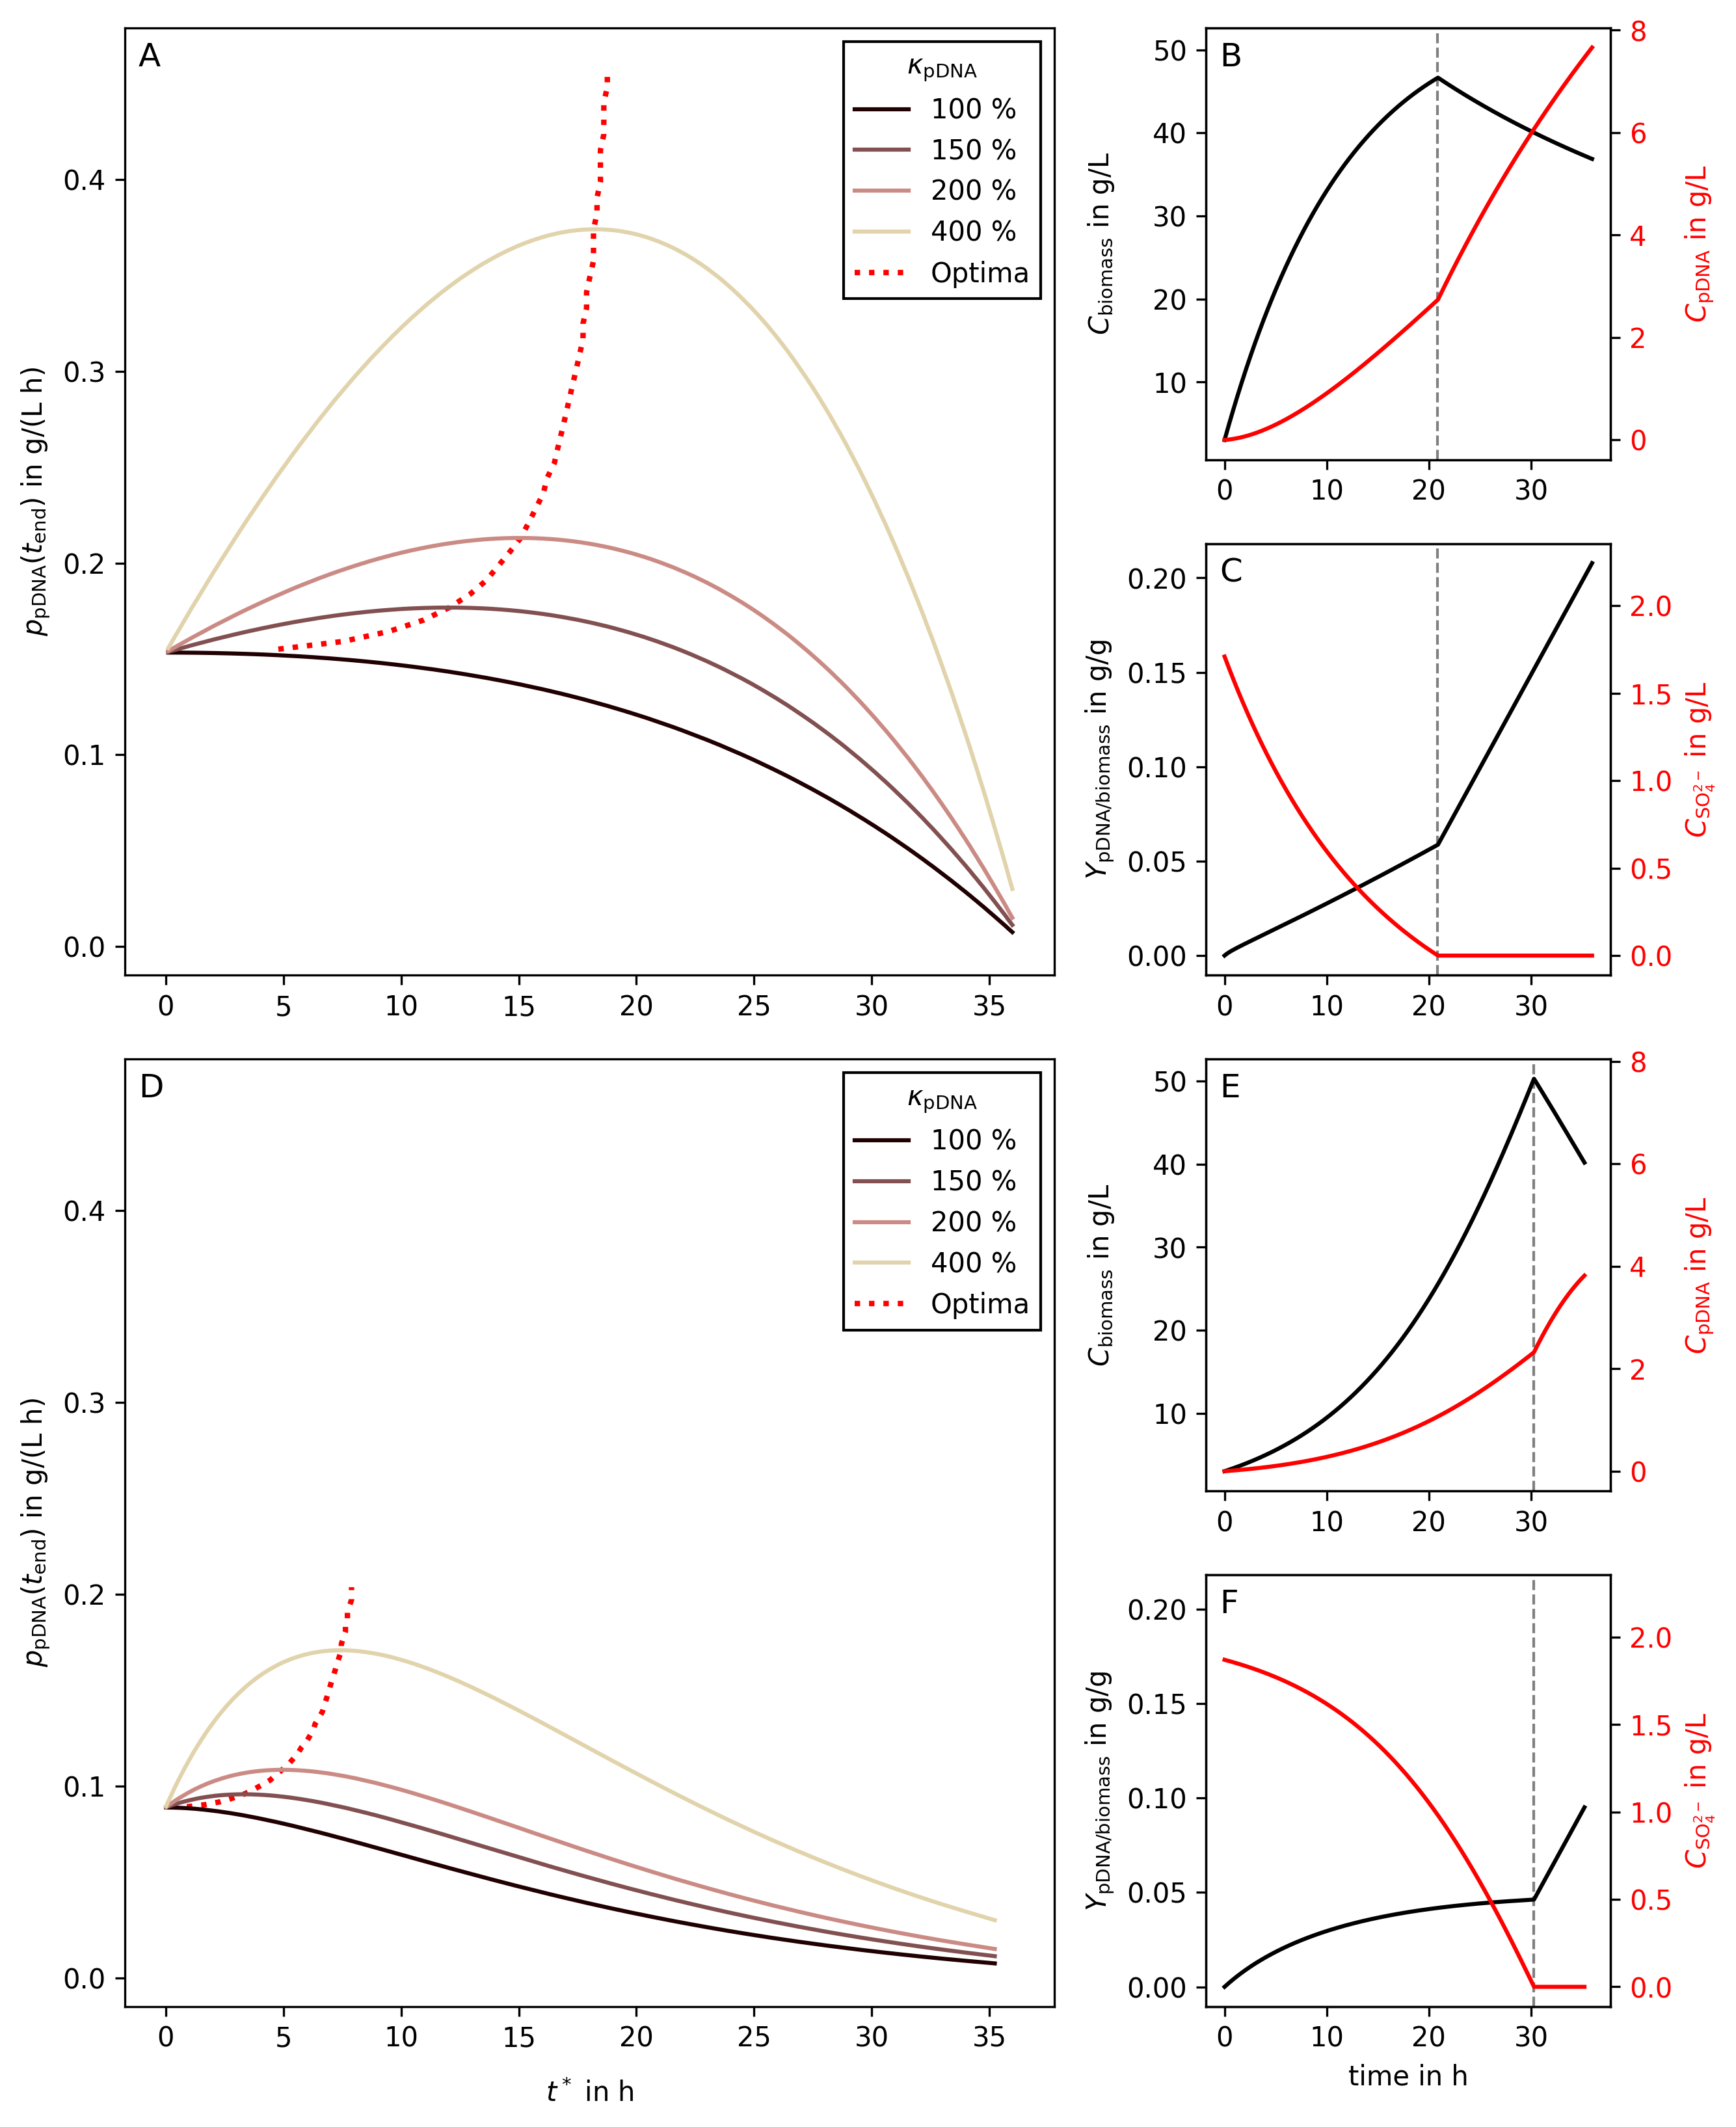

In [17]:
fig = plt.figure(dpi=300,figsize=(9,11))
fig.set_facecolor('w')
gs = fig.add_gridspec(nrows=8, ncols=2, width_ratios=[2.3,1], height_ratios=[1,.2,1,.2]*2)
ax1 = fig.add_subplot(gs[0:4,0])
ax2 = fig.add_subplot(gs[0:2,1])
ax3 = fig.add_subplot(gs[2:4,1])
ax2v2 = ax2.twinx()
ax3v2 = ax3.twinx()

ax4 = fig.add_subplot(gs[4:8,0])
ax5 = fig.add_subplot(gs[4:6,1])
ax6 = fig.add_subplot(gs[6:8,1])
ax5v2 = ax5.twinx()
ax6v2 = ax6.twinx()

#-----------#
#### AX1 ####
#-----------#

tol = 1e-8
colors = ['#200001','#825051','#cb8b85','#e1d3ab','#f7f7e6']
optima_x = []
optima_y = []
l = 0
max_star_time = 100
for q_pDNA_max in q_pDNA_max_levels:
    endpoints          = lin_processed[q_pDNA_max]
    S_0_array          = endpoints[:,0]/.5 * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t_end_array        = endpoints[:,1]
    V_end_array        = endpoints[:,2]
    X_end_array        = endpoints[:,3]
    S_end_array        = endpoints[:,4] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P_end_array        = endpoints[:,5] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G_end_array        = endpoints[:,6] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_start_array = endpoints[:,7]
    t_star_len_array   = t_end_array - t_star_start_array
    productivity       = P_end_array/t_end_array/V_end_array

    if np.any([np.isclose(i,q_pDNA_max) for i in [.1/100,.15/100,.2/100,.4/100]]):
        ax1.plot(t_star_len_array,productivity,
                 color=colors[l], # cm.pink(q_pDNA_max/q_pDNA_min/5),
                 # label=r'$q_{\rm pDNA}^*$ = '+'{:2.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
                 label='{:3.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
        l += 1
    optima_x.append(t_star_len_array[np.argmax(productivity)])
    optima_y.append(np.max(productivity))
    # find index of best process
    if q_pDNA_max == .2/100:
        idx_optimum_zero_q_pDNA = np.argmax(productivity)
    
# plot optima and starvation cutoff
linear_optima = optima_x,optima_y
ax1.plot(optima_x,optima_y,zorder=-1,color='red',linestyle=':',label='Optima',linewidth=2)
# plot starvation cutoff
ylim = ax1.get_ylim()
t_star = optima_x[0]
ax1.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(ylim)
fig.tight_layout()

#################
## AX2 & AX3 ####
#################


def plot_sol(sol):
    S_0 = sol[0] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol[1]                                                    # h
    V   = sol[2]
    X   = sol[3]/V                                                    # g
    S   = sol[4]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol[5]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol[6]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_star = sol[7]                                            # h
    
    lines  = [X,P/X,P,S]
    colors = ['k','k','r','r']
    ylabs  = [r'$C_{\rm biomass}$ in g/L',r'$Y_{\rm pDNA/biomass}$ in g/g', r'$C_{\rm pDNA}$ in g/L', r'$C_{\rm SO_4^{2-}}$ in g/L']
    axes   = [ax2,ax3,ax2v2,ax3v2]

    for j in range(4):
        axes[j].plot(t,lines[j],label=r'$M_{\rm SO_4^{2-}}(t=0)$ ='+'{:6.3f}'.format(S_0)+' mmol/L',color=colors[j])
        axes[j].set_ylabel(ylabs[j],color=colors[j])
    return X,S,P,G,t,t[-1]

results = lin_special_interest[.2/100]
for idx in [idx_optimum_zero_q_pDNA]:
    S_0 = list(results.keys())[idx]
    sol = results[S_0]
    X,S,P,G,t,t_end = plot_sol(sol)

for ax in [ax3v2]:
    tmp = ax.get_ylim()
    ax.set_ylim(np.array(tmp)*1.2)
    
t_star_lin = t[np.isclose(S,0,atol=1e-3)][0]

for ax in [ax2v2,ax3v2]:
    ax.tick_params(axis='y', labelcolor='red')
    
    
#-----------#
#### ax4 ####
#-----------#

tol = 1e-8
colors = ['#200001','#825051','#cb8b85','#e1d3ab','#f7f7e6']
optima_x = []
optima_y = []
l = 0
max_star_time = 100
for q_pDNA_max in q_pDNA_max_levels:
    endpoints          = exp_processed[q_pDNA_max]
    S_0_array          = endpoints[:,0]/.5 * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t_end_array        = endpoints[:,1]
    V_end_array        = endpoints[:,2]
    X_end_array        = endpoints[:,3]
    S_end_array        = endpoints[:,4] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P_end_array        = endpoints[:,5] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G_end_array        = endpoints[:,6] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_start_array = endpoints[:,7]
    t_star_len_array   = t_end_array - t_star_start_array
    productivity       = P_end_array/t_end_array/V_end_array

    if np.any([np.isclose(i,q_pDNA_max) for i in [.1/100,.15/100,.2/100,.4/100]]):
        ax4.plot(t_star_len_array,productivity,
                 color=colors[l], # cm.pink(q_pDNA_max/q_pDNA_min/5),
                 # label=r'$q_{\rm pDNA}^*$ = '+'{:2.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
                 label='{:3.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
        l += 1
    optima_x.append(t_star_len_array[np.argmax(productivity)])
    optima_y.append(np.max(productivity))
    # find index of best process
    if q_pDNA_max == .2/100:
        idx_optimum_zero_q_pDNA = np.argmax(productivity)
    
# plot optima and starvation cutoff
ax4.plot(optima_x,optima_y,zorder=-5,color='red',linestyle=':',label='Optima',linewidth=2)
t_star_exp = optima_x[0]
fig.tight_layout()

#################
## ax5 & ax6 ####
#################


def plot_sol(sol):
    S_0 = sol[0] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol[1]                                                    # h
    V   = sol[2]
    X   = sol[3]/V                                                    # g
    S   = sol[4]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol[5]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol[6]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_star = sol[7]                                            # h
    
    lines  = [X,P/X,P,S]
    colors = ['k','k','r','r']
    ylabs  = [r'$C_{\rm biomass}$ in g/L',r'$Y_{\rm pDNA/biomass}$ in g/g', r'$C_{\rm pDNA}$ in g/L', r'$C_{\rm SO_4^{2-}}$ in g/L']
    axes   = [ax5,ax6,ax5v2,ax6v2]

    for j in range(4):
        axes[j].plot(t,lines[j],label=r'$M_{\rm SO_4^{2-}}(t=0)$ ='+'{:6.3f}'.format(S_0)+' mmol/L',color=colors[j])
        axes[j].set_ylabel(ylabs[j],color=colors[j])
    return X,S,P,G,t,t[-1]

results = exp_special_interest[.2/100]
for idx in [idx_optimum_zero_q_pDNA]:
    S_0 = list(results.keys())[idx]
    sol = results[S_0]
    X,S,P,G,t,t_end = plot_sol(sol)

for ax in [ax6v2]:
    tmp = ax.get_ylim()
    ax.set_ylim(np.array(tmp)*1.2)
    
ax6.set_xlabel('time in h')
for ax in [ax5v2,ax6v2]:
    ax.tick_params(axis='y', labelcolor='red')
    

ax4.set_xlabel(r'$t^*$ in h',labelpad=10)
ax1.set_ylabel(r'$p_{\rm pDNA}(t_{\rm end})$ in g/(L h)')
ax4.set_ylabel(r'$p_{\rm pDNA}(t_{\rm end})$ in g/(L h)')
ax4.legend(fancybox=False,edgecolor='k',loc='upper right',framealpha=1,title=r'$\kappa_{\rm pDNA}$ ')
ax1.legend(fancybox=False,edgecolor='k',loc='upper right',framealpha=1,title=r'$\kappa_{\rm pDNA}$ ')

for A,B in [(ax1,ax4),(ax2,ax5),(ax3,ax6),(ax2v2,ax5v2),(ax3v2,ax6v2)]:
    A_ylim = A.get_ylim()
    B_ylim = B.get_ylim()
    C_ylim = (np.min([A_ylim[0],B_ylim[0]]),np.max([A_ylim[1],B_ylim[1]]))
    A.set_ylim(*C_ylim)
    B.set_ylim(*C_ylim)
    
    A_xlim = A.get_xlim()
    B_xlim = B.get_xlim()
    C_xlim = (np.min([A_xlim[0],B_xlim[0]]),np.max([A_xlim[1],B_xlim[1]]))
    A.set_xlim(*C_xlim)
    B.set_xlim(*C_xlim)
    
for ax in [ax5,ax6]:
    ylim = ax.get_ylim()
    t_star = t[np.isclose(S,0,atol=1e-3)][0]
    ax.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
    ax.set_ylim(ylim)
    
# plot starvation cutoff
ylim = ax4.get_ylim()
ax4.plot([t_star_exp]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax4.set_ylim(ylim)

for ax in [ax2,ax3]:
    ylim = ax.get_ylim()
    ax.plot([t_star_lin]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
    ax.set_ylim(ylim)

    
import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E','F','G'],[ax1,ax2,ax3,ax4,ax5,ax6]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
fig.align_ylabels()
fig.align_xlabels()
fig.tight_layout()
fig.show()